<a href="https://colab.research.google.com/github/ankesh86/IntroductionToMachineLearning/blob/main/EECE5644_Assgn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.3 MB/s eta 0:00:00


In [10]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
#np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

In [11]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['mu'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)

    # Decide randomly which samples will come from each component u_i ~ Uniform(0, 1) for i = 1, ..., N (or 0, ... , N-1 in code)
    u = np.random.rand(N)
    # Determine the thresholds based on the mixture weights/priors for the GMM, which need to sum up to 1
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)
        labels[indices] = l * np.ones(Nl) - 1
        # If dealing with a univariate Gaussian, use norm.rvs to sample RVs and not the multivariate version
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['mu'][l-1], pdf_params['Sigma'][l-1], Nl)

    return X, labels

In [12]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    # The epsilon is just to account for the two extremes of the ROC curve (TPR=FPR=0 and TPR=FPR=1)
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]

    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]

    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas

def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}

    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['TNR'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['FPR'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['FNR'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['TPR'] = len(ind_11) / N_labels[1]

    return class_metrics

In [13]:
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance matrix parameters would be estimated from training samples.

    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """

    # First, estimate the class-conditional PDF mean and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z


# ERM classification rule (min prob. of error classifier IF 0-1 loss)
def perform_erm_classification(X, Lambda, gmm_params, C):
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['mu'][i], gmm_params['Sigma'][i]) for i in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)

    # If 0-1 loss, you could instead compute MAP result: np.argmax(class_posteriors, axis=0)
    return np.argmin(risk_mat, axis=0)

In [14]:
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.7, 0.3])
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['mu'] = np.array([
        [-1, 1, -1, 1],  # Mean for class 0
        [1, 1, 1, 1]     # Mean for class 1
    ])  # Gaussian distributions means
gmm_pdf['Sigma'] = np.array([
        [[2, -0.5, 0.3, 0], [-0.5, 1, -0.5, 0], [0.3, -0.5, 1, 0], [0, 0, 0, 2]],  # Covariance for class 0
        [[1, 0.3, -0.2, 0], [0.3, 2, 0.3, 0], [-0.2, 0.3, 1, 0], [0, 0, 0, 3]]      # Covariance for class 1
    ])  # Gaussian distributions covariance matrices

X, labels = generate_data_from_gmm(N, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)


[7036 2964]


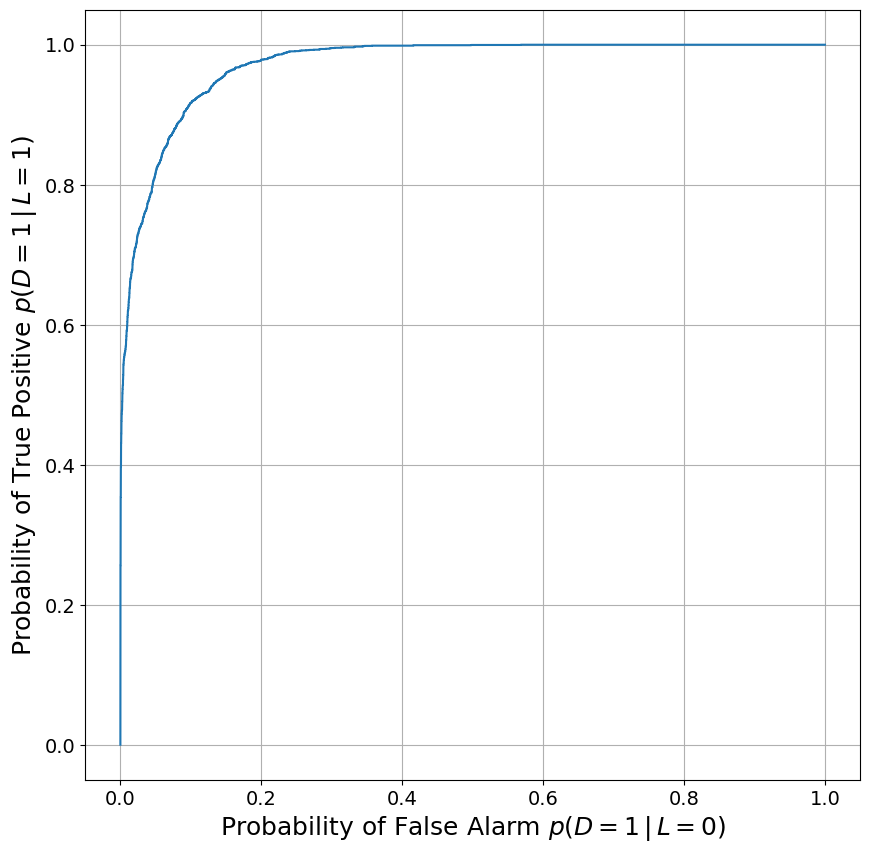

In [15]:
# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], gmm_pdf['Sigma'][l]) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $p(D=1\,|\,L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $p(D=1\,|\,L=1)$")

plt.grid(True)
display(fig_roc)
fig_roc;

Min Empirical Pr(error) for ERM = 0.088
Min Empirical Gamma = 2.283
Min Theoretical Pr(error) for ERM = 0.088
Min Theoretical Gamma = 2.333


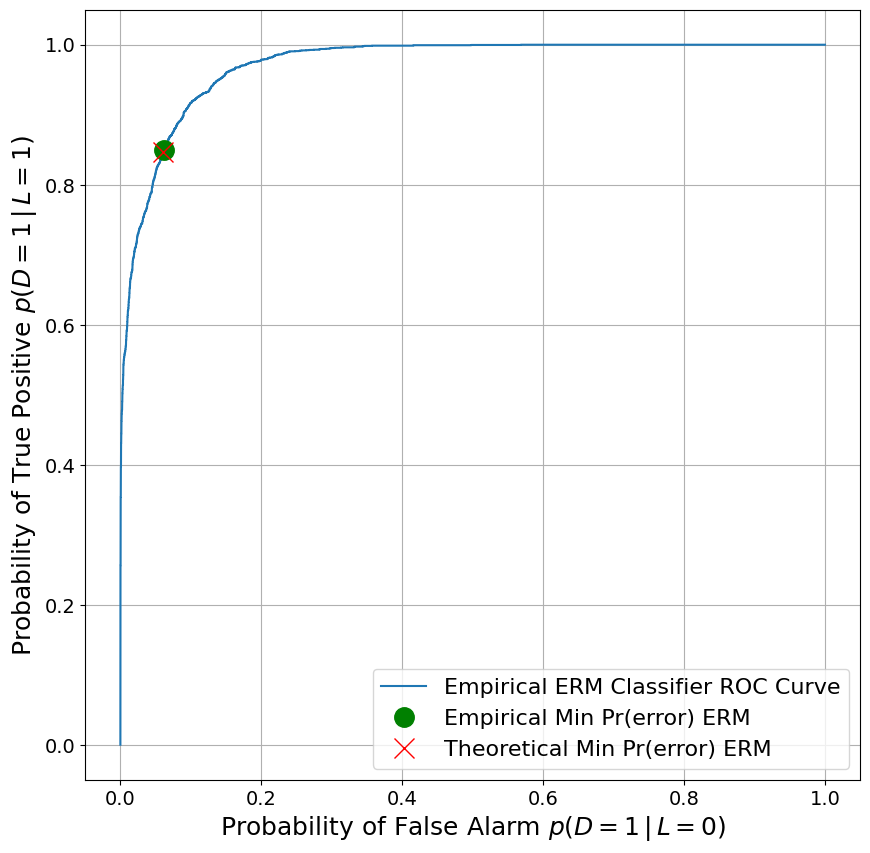

In [16]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['priors'][0] / gmm_pdf['priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['FPR'] * gmm_pdf['priors'][0] +
                               class_metrics_map['FNR'] * gmm_pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min Pr(error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['FPR'], class_metrics_map['TPR'], 'rx', label="Theoretical Min Pr(error) ERM", markersize=14)
plt.legend()

print("Min Empirical Pr(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical Pr(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

Min Naive Pr(error) for ERM = 0.101
Min Naive Gamma = 4.101


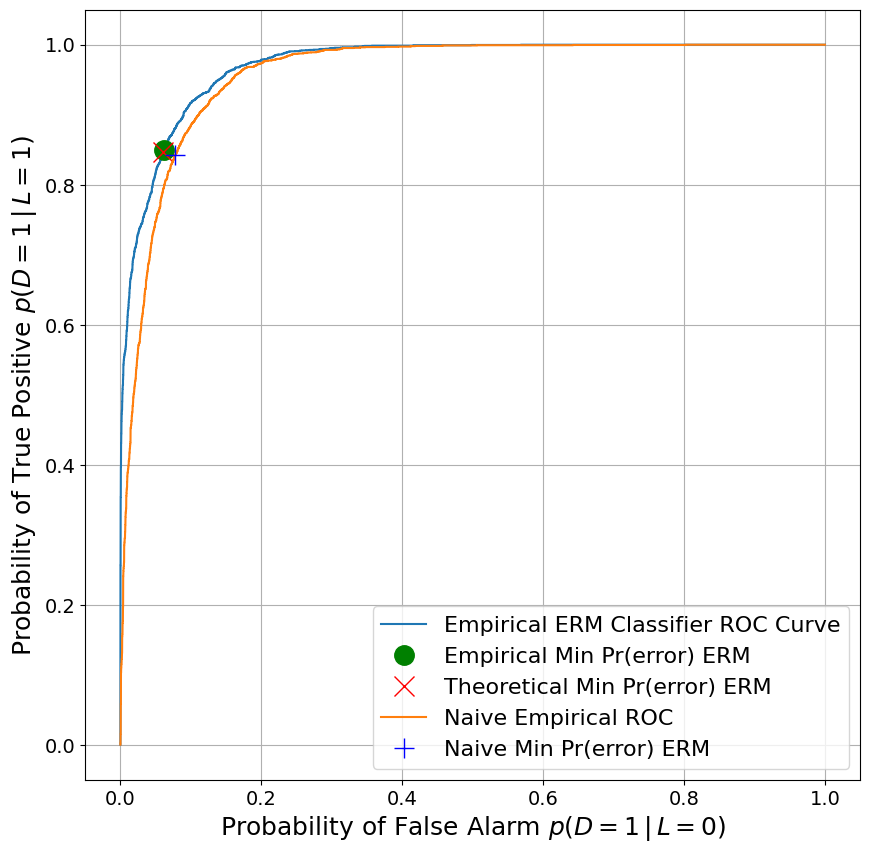

In [17]:
# Naive Bayes case assume conditional independence with features, zero covariance, zero off-diagonals
# Happens to be identity matrix in this question
naive_class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['mu'][l], np.eye(n)) for l in L])
# Class conditional log likelihoods equate to log gamma at the decision boundary
discriminant_score_naive = np.log(naive_class_conditional_likelihoods[1]) - np.log(
    naive_class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_naive, gammas_naive = estimate_roc(discriminant_score_naive, labels)

# Pr(error; γ) = p(D = 1|L = 0; γ)p(L = 0) + p(D = 0|L = 1; γ)p(L = 1)
prob_error_naive = np.array((roc_naive['p10'], (1 - roc_naive['p11']))).T.dot(N_per_l / N)

# Min prob error for the naive classifier gamma thresholds
min_prob_error_naive = np.min(prob_error_naive)
min_ind_naive = np.argmin(prob_error_naive)

# Plot naive min prob error
ax_roc.plot(roc_naive['p10'], roc_naive['p11'], label="Naive Empirical ROC")
ax_roc.plot(roc_naive['p10'][min_ind_naive], roc_naive['p11'][min_ind_naive], 'b+', label="Naive Min Pr(error) ERM",
            markersize=14)
ax_roc.legend()

print("Min Naive Pr(error) for ERM = {:.3f}".format(min_prob_error_naive))
print("Min Naive Gamma = {:.3f}".format(np.exp(gammas_naive[min_ind_naive])))

display(fig_roc)